<a href="https://colab.research.google.com/github/pradhap1125/Computer_Vision_Home_Work/blob/main/Computer_Vision_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [153]:
# Load and normalize the image
def load_image(path):
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  print("Image shape:", img.shape)
  # Resize for simplicity
  img = cv2.resize(img, (256, 256))
  #Normalization
  img = img.astype(np.float32) / 255.0
  return img

# Define Gaussian kernel (7x7)
def get_gaussian_kernal():
  gaussian_kernel = cv2.getGaussianKernel(7, 1)
  gaussian_kernel = gaussian_kernel @ gaussian_kernel.T
  return gaussian_kernel

#apply the kernel to each color channel
def convolve(image, kernel):
    blurred = np.zeros_like(image)
    for i in range(3):  # B, G, R channels
       blurred[:, :, i] = cv2.filter2D(image[:, :, i], -1, kernel)
    return blurred

#Downsampling the image by reducing the size by half
def downsample(image):
    return image[::2, ::2]

def upsample(image,kernal):
    h, w, c = image.shape
    up = np.zeros((h*2, w*2, c), dtype=np.float32)
    up[::2, ::2, :] = image  # place pixels in correct positions for all channels
    # Apply blur to interpolate missing pixels
    return convolve(up, kernal * 4)  # scaling kernel to maintain intensity

# Build Gaussian pyramid
def gaussian_pyramid(img,levels):
  kernal=get_gaussian_kernal()
  G = [img]
  for i in range(levels):
      blurred = convolve(G[-1], kernal)
      down = downsample(blurred)
      G.append(down)
  #visualize Gaussian pyramid
  for i, lap in enumerate(G[1:]):
      plt.subplot(1, levels, i+1)
      plt.imshow(np.clip(lap, 0, 1))
      plt.title(f'G {i+1}')
      plt.axis('off')
  plt.show()
  return G

#Build Laplacian pyramid
def laplacian_pyramid(gaussian_pyramids,levels):
  kernal=get_gaussian_kernal()
  L = []
  for i in range(levels):
      up = upsample(gaussian_pyramids[i+1],kernal)
      # Resize upsampled to match the original size
      h, w, _ = gaussian_pyramids[i].shape
      up = up[:h, :w, :]
      lap = gaussian_pyramids[i] - up
      L.append(lap)
  L.append(gaussian_pyramids[-1])  # smallest level
  #visualize Laplacian levels
  for i, lap in enumerate(L):
      plt.subplot(1, levels+1, i+1)
      plt.imshow(np.clip(lap, 0, 1))
      plt.title(f'L {i}')
      plt.axis('off')
  plt.show()
  return L

#Reconstructing the image from gaussian and laplacian pyramids
def reconstruct_image(gaussian_pyramids,laplacian_pyramids,levels):
  # Start with the smallest one
  kernal=get_gaussian_kernal()
  recon = gaussian_pyramids[-1]
  for i in reversed(range(levels)):
      up = upsample(recon,kernal)
      up = cv2.resize(up, (laplacian_pyramids[i].shape[1], laplacian_pyramids[i].shape[0]))
      recon = up + laplacian_pyramids[i]

  # Display reconstructed image
  plt.imshow(np.clip(recon, 0, 1))
  plt.title('Reconstructed Image')
  plt.axis('off')
  plt.show()

#Blend the Laplacian Pyramids Using the Mask
def blend_pyramids(apple_laplacian_pyramids, orange_laplacian_pyramids, mask_gaussian_pyramids):
  blended= []
  for LA, LB, GR in zip(apple_laplacian_pyramids, orange_laplacian_pyramids, mask_gaussian_pyramids):
      # blend = GR(I,j) * LA(I,j) + (1 - GR(I,j)) * LB(I,j)
      blend = GR * LA + (1 - GR) * LB
      blended.append(blend)
  return blended

# Collapse the final pyramid to get hybrid image
def reconstruct_hybrid(hybrid_pyramid, kernel):
    current = hybrid_pyramid[-1]
    for i in range(len(hybrid_pyramid) - 2, -1, -1):
        up = upsample(current, kernel)
        h, w, _ = hybrid_pyramid[i].shape
        up = cv2.resize(up, (w, h))
        current = up + hybrid_pyramid[i]
    return np.clip(current * 255, 0, 255).astype(np.uint8)

 #--------------------------------Using Build in cv2 package--------------------------------

 # Build Gaussian pyramid using OpenCV pyrDown
def gaussian_pyramid_cv2(img, levels):
    G = [img.astype(np.float32)]
    for _ in range(levels):
        img = cv2.pyrDown(img)
        G.append(img.astype(np.float32))
  #visualize Gaussian pyramid
    for i, lap in enumerate(G[1:]):
        plt.subplot(1, levels, i+1)
        plt.imshow(np.clip(lap, 0, 1))
        plt.title(f'G {i+1}')
        plt.axis('off')
    plt.show()
    return G

# Build Laplacian pyramid using OpenCV pyrUp
def laplacian_pyramid_cv2(gaussian_pyr):
    L = []
    for i in range(len(gaussian_pyr) - 1):
        size = (gaussian_pyr[i].shape[1], gaussian_pyr[i].shape[0])
        up = cv2.pyrUp(gaussian_pyr[i + 1], dstsize=size)
        lap = gaussian_pyr[i] - up
        L.append(lap)
    L.append(gaussian_pyr[-1])  # smallest level
    #visualize Laplacian levels
    for i, lap in enumerate(L):
        plt.subplot(1, levels+1, i+1)
        plt.imshow(np.clip(lap, 0, 1))
        plt.title(f'L {i}')
        plt.axis('off')
    plt.show()
    return L

Image shape: (448, 624, 3)


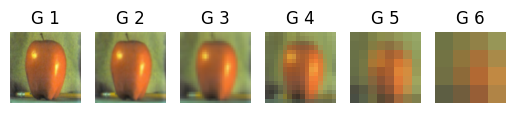

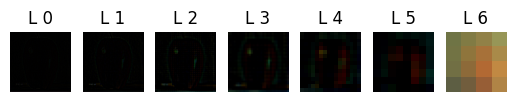

In [154]:
level=6
#constructing laplacian pyramid for apple
img=load_image('/content/CV_HW1/apple.png')
apple_gaussian_pyramids=gaussian_pyramid(img,level)
apple_laplacian_pyramids=laplacian_pyramid(apple_gaussian_pyramids,level)
#reconstruct_image(apple_gaussian_pyramids,apple_laplacian_pyramids,level)


Image shape: (448, 624, 3)


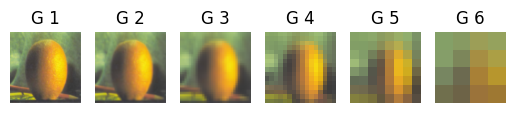

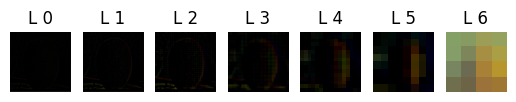

In [155]:
#constructing laplacian pyramid for apple
img=load_image('/content/CV_HW1/orange.png')
orange_gaussian_pyramids=gaussian_pyramid(img,level)
orange_laplacian_pyramids=laplacian_pyramid(orange_gaussian_pyramids,level)
#reconstruct_image(orange_gaussian_pyramids,orange_laplacian_pyramids,level)

Image shape: (448, 624, 3)


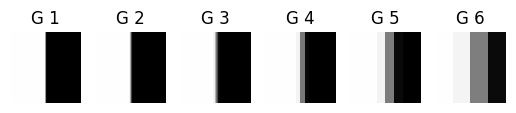

In [156]:
#constructing gaussian pyramid for mask
img=load_image('/content/CV_HW1/mask.png')
mask_gaussian_pyramids=gaussian_pyramid(img,level)

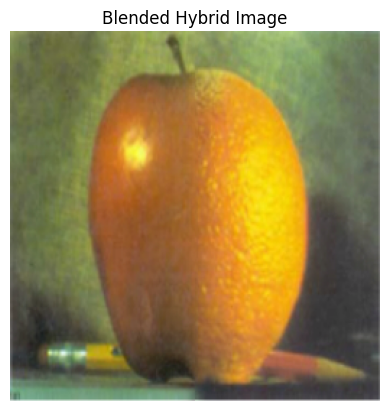

In [157]:
blended=blend_pyramids(apple_laplacian_pyramids, orange_laplacian_pyramids, mask_gaussian_pyramids)

#reconstruct upwards
hybrid_image = reconstruct_hybrid(blended,get_gaussian_kernal())

#Show result
plt.imshow(hybrid_image)
plt.title("Blended Hybrid Image")
plt.axis('off')
plt.show()


Above is the hybrid image created using custom method written in python for gaussian and laplacian pyramids. Initially I tried with a level 3, But the image was not clear. So I increased the level to 6 and got the above image. I can see the images got merged. I have used the below 7X7 Gaussian kernal to achieve this result. Please refer method ***get_gaussian_kernal()*** for the same.


> [[1.96519161e-05 2.39409349e-04 1.07295826e-03 1.76900911e-03
  1.07295826e-03 2.39409349e-04 1.96519161e-05]
 [2.39409349e-04 2.91660295e-03 1.30713076e-02 2.15509428e-02
  1.30713076e-02 2.91660295e-03 2.39409349e-04]
 [1.07295826e-03 1.30713076e-02 5.85815363e-02 9.65846250e-02
  5.85815363e-02 1.30713076e-02 1.07295826e-03]
 [1.76900911e-03 2.15509428e-02 9.65846250e-02 1.59241126e-01
  9.65846250e-02 2.15509428e-02 1.76900911e-03]
 [1.07295826e-03 1.30713076e-02 5.85815363e-02 9.65846250e-02
  5.85815363e-02 1.30713076e-02 1.07295826e-03]
 [2.39409349e-04 2.91660295e-03 1.30713076e-02 2.15509428e-02
  1.30713076e-02 2.91660295e-03 2.39409349e-04]
 [1.96519161e-05 2.39409349e-04 1.07295826e-03 1.76900911e-03
  1.07295826e-03 2.39409349e-04 1.96519161e-05]]

In order to verify whether I'm able reconstruct the image using gaussian and laplacian pyramids, I created a method ***reconstruct_image()*** and tried it and got the original image. This proves my program is correct. I have commented the code for recreating the image as it is not part of the assignment.

---

I also tried using the built in methods of cv2 library to generate gaussian and
laplacian pyramids to compare the results and to my surprise, I almost got the same result. Although I don't have any control on Kernal in this approach, I believe it should be almost the same. Please refere the below result for built in library.


---
If you notice the methods ***laplacian_pyramid()*** and ***laplacian_pyramid_cv2()***, The smallest level of the Gaussian pyramid is added as the last level of the Laplacian pyramid because there is no smaller image to subtract from it. This level represents the low-frequency details of the image and is essential for accurately reconstructing the original image from the Laplacian pyramid. Without including this base level, the reconstruction process would lose important image information. Initially in my approach, I didn't added it and got a poor image as result, after exploring the internet and chatgpt, I found this and added the smallest level of gaussian pyramid and got a better result.




Image shape: (448, 624, 3)


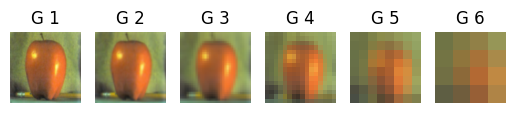

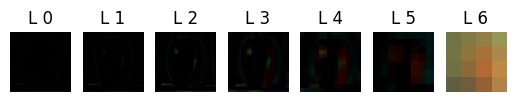

In [158]:
#constructing laplacian pyramid for apple using built in library
img=load_image('/content/CV_HW1/apple.png')
apple_gaussian_pyramids=gaussian_pyramid_cv2(img,level)
apple_laplacian_pyramids=laplacian_pyramid_cv2(apple_gaussian_pyramids)

Image shape: (448, 624, 3)


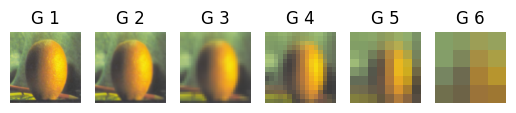

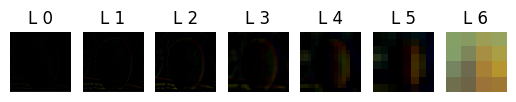

In [159]:
#constructing laplacian pyramid for apple using built in library
img=load_image('/content/CV_HW1/orange.png')
orange_gaussian_pyramids=gaussian_pyramid_cv2(img,level)
orange_laplacian_pyramids=laplacian_pyramid_cv2(orange_gaussian_pyramids)

Image shape: (448, 624, 3)


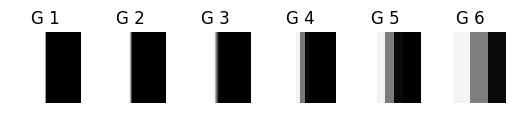

In [160]:
#constructing gaussian pyramid for mask using built in library
img=load_image('/content/CV_HW1/mask.png')
mask_gaussian_pyramids=gaussian_pyramid_cv2(img,level)

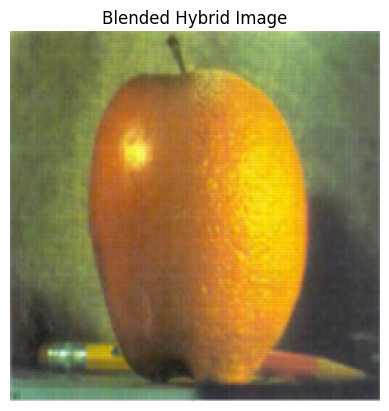

In [161]:
blended=blend_pyramids(apple_laplacian_pyramids, orange_laplacian_pyramids, mask_gaussian_pyramids)

#reconstruct upwards
hybrid_image = reconstruct_hybrid(blended,get_gaussian_kernal())

#Show result
plt.imshow(hybrid_image)
plt.title("Blended Hybrid Image")
plt.axis('off')
plt.show()
